# Imports and Data Preparation

In [40]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Imports for time series analysis
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.vector_ar.var_model import VAR

# Imports for regression
from sklearn.model_selection import TimeSeriesSplit, cross_validate, train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge

# Imports for evaluation
from sklearn.metrics import r2_score

# Imports for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from IPython.display import Image

In [2]:
df = pd.read_csv("../00_data/data_with_calc_fields.csv", sep=';', decimal=",")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index('datetime')
df = df.drop("date", axis=1)

## Feature Engineering

In [47]:
# Add column with 24h max
df["solar_24h_max"] = df.solar_generation_actual.rolling(24,  min_periods=1).max()

# Calculate a moving average FOR EACH HOUR: MOV_AVG_Thur <-- AVG(Mon 1am, Tue 1am, Wed 1am, Thur 1am)
for i in range (24):
    df.loc[df.index.hour == i,"hourly_moving_avg"] = df.loc[df.index.hour == i,"solar_generation_actual"].rolling(4,  min_periods=1).mean()
    df.loc[df.index.hour == i,"hourly_moving_avg_2"] = df.loc[df.index.hour == i,"solar_generation_actual"].rolling(2,  min_periods=1).mean()
    df.loc[df.index.hour == i,"hourly_moving_avg_7"] = df.loc[df.index.hour == i,"solar_generation_actual"].rolling(7,  min_periods=1).mean()
    
# Add columns with forecast errors shiftet by one hour
df["solar_forecast_error_shifted"] = df.solar_forecast_error.shift(24)
df.loc["2016-01-01 00:00:00":"2016-01-01 23:00:00","solar_forecast_error_shifted"] = 0 # to avoid NaN value
df["wind_forecast_error_shifted"] = df.wind_forecast_error.shift(24)
df.loc["2016-01-01 00:00:00":"2016-01-01 23:00:00","wind_forecast_error_shifted"] = 0 # to avoid NaN value
df["price_difference_shifted"] = df.price_diff.shift(24)
df.loc["2016-01-01 00:00:00":"2016-01-01 23:00:00","price_difference_shifted"] = 0 # to avoid NaN value

In [48]:
df.head(25)

,hour,day_ahead_price,intraday_price,price_diff,solar_capacity,solar_generation_actual,wind_capacity,wind_generation_actual,wind_generation_forecast,solar_generation_forecast,...,season,month,weekday,solar_24h_max,hourly_moving_avg,hourly_moving_avg_2,hourly_moving_avg_7,solar_forecast_error_shifted,wind_forecast_error_shifted,price_difference_shifted
datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0,23.86,29.34,5.48,39021,0,44325,8648,6033,0,...,0,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2016-01-01 01:00:00,1,22.39,24.28,1.89,39021,0,44325,8579,7421,0,...,0,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2016-01-01 02:00:00,2,20.59,25.26,4.67,39021,0,44325,8542,7266,0,...,0,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2016-01-01 03:00:00,3,16.81,20.24,3.43,39021,0,44325,8443,7180,0,...,0,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2016-01-01 04:00:00,4,17.41,21.94,4.53,39021,0,44325,8295,7016,0,...,0,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2016-01-01 05:00:00,5,17.02,23.50,6.48,39021,0,44325,7319,6787,0,...,0,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2016-01-01 06:00:00,6,15.86,21.87,6.01,39021,0,44325,6574,6492,0,...,0,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2016-01-01 07:00:00,7,18.16,25.13,6.97,39021,0,44325,5624,6058,0,...,0,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2016-01-01 08:00:00,8,17.73,24.52,6.79,39021,137,44325,4644,5510,137,...,0,1,4,137.0,137.0,137.0,137.0,0.0,0.0,0.00


# Testing two options for forecast error prediction

### Thoughts on evaluation

By default cross_val_score seems to calculate the coefficient of determination (R^2) for regression instead of accuracy (https://www.quora.com/What-does-sklearn-cross_val_score-do-in-a-regression-problem). Recall: Acurracy measures if the class has been predicted correctly or not.

According to scikit-learn (https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) the follwing metrics are appropriate for regression:

 - Explained variance score ('explained_variance')
 - Mean absolute error ('neg_mean_absolute_error')
 - Mean squared error ('neg_mean_squared_error')
 - Mean squared logarithmic error ('neg_mean_squared_log_error')
 - Median absolute error ('neg_median_absolute_error')
 - R² score, the coefficient of determination ('r2')

Calulating Mean Squared Logarithmic Error yields the following error: "Mean Squared Logarithmic Error cannot be used when targets contain negative values." Thus it is not used for evaluation.

In [23]:
# Dict containing the scorers to be used
scoring = {'explained_variance': 'explained_variance',
           'neg_mean_absolute_error': 'neg_mean_absolute_error',
           'neg_mean_squared_error': 'neg_mean_squared_error',
           'neg_median_absolute_error': 'neg_median_absolute_error',
           'r2': 'r2'
          }

# Function which returns a table with scores achieved with different parameters
def print_scores(scores_list, param_range):
    scores_list = [{k:v.mean() for k,v in alpha.items()} for alpha in scores_list]
    scores_df = pd.DataFrame(scores_list, index=param_range).drop(["fit_time", "score_time"],axis=1)
    scores_df.columns=["expl_var",
                       "mean_abs_err",
                       "mean_sqrd_err",
                       "median_abs_err",
                       "r2"]
    scores_df["expl_var"] = scores_df["expl_var"].round(4)
    scores_df["mean_abs_err"] = scores_df["mean_abs_err"].abs().round(2)
    scores_df["mean_sqrd_err"] = scores_df["mean_sqrd_err"].abs().round(1)
    scores_df["median_abs_err"] = scores_df["median_abs_err"].abs().round(3)
    scores_df["r2"] = scores_df["r2"].round(4)
    return scores_df

## Option 1: Time Series Analysis

In this option we assume the forecast error does depend on a specific point in time (e.g. 07-07-2016 13:00). Thus we cannot use classical ML models (e.g. Regression Trees). Instead we have to use calssical time series analysis methods like ARIMA. Besides, we have to use TimeSeriesSplit instead of classical CV.

First, the dataset will be splitted into a training and a test part. The first one is used for hyperparameter tuning and CV, the second one is used as holdout set for final evaluation. Since we assume the forecast error depending on a specific point in time, we cannot split the whole dataset randomly. Instead for final evaluation we will use the sencond half of 2017 which equals 25% of the hole dataset.

In [414]:
df_SG = df[["solar_generation_actual"]]

In [415]:
model = AR(df_SG)

/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [416]:
model_fit = model.fit()
yhat = model_fit.predict(len(df_SG), len(df_SG))
print(yhat)

17542    5.534279
dtype: float64


/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [101]:
model = ARMA(df_SG, order=(0, 1))
model_fit = model.fit(disp=False)
yhat = model_fit.predict(len(df_SG), len(df_SG))
print(yhat)

/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17542    2130.752525
dtype: float64


/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [115]:
df_VAR = df[["solar_generation_actual","solar_forecast_error"]]

# fit model
model = VAR(df_VAR)
model_fit = model.fit()
# make prediction
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)

[[165.71293742  -5.06380007]]


## Option 2: Classical Predictors

In this option we assume the forecast error does not depend on a specific point in time (e.g. 07-07-2016 13:00). Thus we can use classical ML models (e.g. Regression Trees) and classical CV instead of TimeSeriesSplit. Nevertheless, we explicitly can use moving averages and shifted values.

### Splitting into dependent and independent variables
First, the dataset will be splitted into dependent (the ones used for prediction) and independent variables (the one to be predicted).

In [49]:
# Set with which features the prediction should be made and with feature should be predicted
y = df.solar_forecast_error
X = df.drop(["solar_forecast_error",
             "solar_generation_actual",
             "wind_forecast_error_percent",
             "solar_forecast_error_percent","wind_capacity",
             "wind_generation_actual",
             "wind_generation_forecast",
             "wind_forecast_error",
             "pricediff_percent",
             "total_generation_forecast",
             "total_generation_actual",
             "forecast_error",
             "mov_avg_1_wind_forecast_error",
             "price_diff"], axis=1)
X = X.reset_index()
X = X.drop("datetime", axis=1)
X.head(3)

,hour,day_ahead_price,intraday_price,solar_capacity,solar_generation_forecast,mov_avg_30_forecast_error,mov_avg_30_wind_forecast_error,mov_avg_30_solar_forecast_error,mov_avg_10_forecast_error,mov_avg_10_wind_forecast_error,...,season,month,weekday,solar_24h_max,hourly_moving_avg,hourly_moving_avg_2,hourly_moving_avg_7,solar_forecast_error_shifted,wind_forecast_error_shifted,price_difference_shifted
0,0,23.86,29.34,39021,0,2615.000000,2615.000000,0.0,2615.000000,2615.000000,...,0,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,22.39,24.28,39021,0,1885.488194,1885.488194,0.0,1883.464583,1883.464583,...,0,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,20.59,25.26,39021,0,1681.760861,1681.760861,0.0,1679.286653,1679.286653,...,0,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Splitting into training and test sets

Sedond, the dataset will be splitted into a training and a test part. The first one is used for hyperparameter tuning and CV, the second one is used as holdout set for final evaluation. Since we assume the forecast error not depending on a specific point in time, we can split the whole dataset randomly.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Model 1: Decision Tree Regressor

In [51]:
scores_list = []
param_range = range(3,11)

for i in param_range:
    DTR = DecisionTreeRegressor(max_depth=i)
    scores_list.append(cross_validate(DTR, X_train, y_train, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
3,0.5106,248.82,239158.6,15.025,0.5105
4,0.5982,225.35,196405.1,19.013,0.5981
5,0.6537,208.84,169566.1,15.153,0.6534
6,0.6647,203.60,163884.0,12.745,0.6644
7,0.6666,200.92,162918.3,12.364,0.6663
8,0.6573,203.52,167305.4,12.219,0.6571
9,0.6445,205.92,173447.1,12.188,0.6443
10,0.6275,209.70,181551.1,12.271,0.6273


In [53]:
# Final Evaluation

DTR = DecisionTreeRegressor(max_depth=6)
DTR.fit(X_train, y_train)
y_pred = DTR.predict(X_test)
r2_score(y_test, y_pred)

0.6545185877140882

### Model 2: Random Forest Regressor

In [56]:
scores_list = []
param_range = range(3,20)

for depth in param_range:
    RFR = RandomForestRegressor(max_depth=depth)
    scores_list.append(cross_validate(RFR, X_train, y_train, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
3,0.5694,244.91,210414.9,65.950,0.5692
4,0.6447,212.35,173650.6,18.799,0.6445
5,0.6879,199.38,152657.6,17.734,0.6877
6,0.7136,189.89,140130.4,14.178,0.7133
7,0.7316,182.42,131262.8,12.121,0.7313
8,0.7442,177.88,125067.9,11.589,0.7439
9,0.7529,174.71,120778.5,11.274,0.7526
10,0.7588,172.33,117925.1,11.428,0.7585
11,0.7613,171.05,116691.1,10.975,0.7610
12,0.7633,170.47,115685.8,10.976,0.7631


In [57]:
# Final Evaluation

RFR = RandomForestRegressor(max_depth=16)
RFR.fit(X_train, y_train)
y_pred = RFR.predict(X_test)
r2_score(y_test, y_pred)

0.7472471094108439

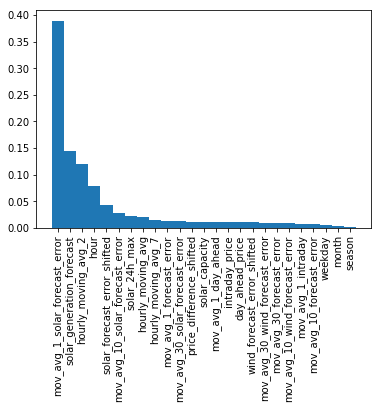

[(0.3892, 'mov_avg_1_solar_forecast_error'),
 (0.1439, 'solar_generation_forecast'),
 (0.1198, 'hourly_moving_avg_2'),
 (0.0784, 'hour'),
 (0.0432, 'solar_forecast_error_shifted'),
 (0.027, 'mov_avg_10_solar_forecast_error'),
 (0.0216, 'solar_24h_max'),
 (0.0206, 'hourly_moving_avg')]

In [60]:
# See how important the features of the data frame are for the prediction with Random Forests

RFR = RandomForestRegressor(max_depth=16)
RFR.fit(X,y)
features = sorted(zip(map(lambda x: round(x, 4), RFR.feature_importances_), X.columns), reverse=True)
ys, labels = zip(*features)
xs = np.arange(len(labels)) 
width = 1
plt.bar(xs, ys, width, align='center')
plt.xticks(xs, labels, rotation='vertical')
plt.show()
features[0:8]

The solar forcast error of the previous hour has the biggest impact on the prediction of the current solar forcast error.

### Model 3: Ridge Regression

In [61]:
scores_list = []
param_range = (1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000)

for alpha in param_range:
    RR = Ridge(alpha=alpha)
    scores_list.append(cross_validate(RR, X_train, y_train, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
1,0.4730,340.17,256954.3,214.723,0.4729
10,0.4730,340.17,256954.2,214.725,0.4729
100,0.4730,340.15,256952.7,214.705,0.4729
1000,0.4731,339.98,256942.8,213.824,0.4729
10000,0.4728,338.91,257114.9,210.454,0.4726
100000,0.4673,338.06,259826.5,205.379,0.4672
1000000,0.4557,339.27,265493.0,203.664,0.4556
10000000,0.4481,339.62,269199.1,200.982,0.4480
100000000,0.4362,337.22,275053.0,192.115,0.4361


In [62]:
# Final Evaluation

RR = Ridge(alpha=100000)
RR.fit(X_train, y_train)
y_pred = RR.predict(X_test)
r2_score(y_test, y_pred)

0.4580452867782907

### Model 4: AdaBoost

In [81]:
# Boosting: combining several weak learners to form a strong learner.
# Weak learner: Model doing slightly better than random guessing (e.g. a decision tree with low depth)
# Incorrectly predicted data points get more weight in the next step
# Regression: Weighted average (AdaBoostRegressor)

scores_list = []
param_range = [100]

ABR = AdaBoostRegressor(base_estimator=RandomForestRegressor(max_depth=5), n_estimators=50) # Default is with DecisionTreeRegressor(max_depth=3)
scores_list.append(cross_validate(ABR, X_train, y_train, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
100,0.6244,312.48,183086.0,236.663,0.6236


In [80]:
# Final Evaluation

ABR = AdaBoostRegressor(base_estimator=RandomForestRegressor(max_depth=5), n_estimators=50)
ABR.fit(X_train, y_train)
y_pred = ABR.predict(X_test)
r2_score(y_test, y_pred)

0.5428694411026741

### Model 5: Gradient Boosting

In [64]:
scores_list = []
param_range = [6]

GBR = GradientBoostingRegressor(max_depth=6) # Parameter max_features="sqrt" reduces variance, but also reduces CV score to 0.80
scores_list.append(cross_validate(GBR, X_train, y_train, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
6,0.8111,157.31,92300.9,19.398,0.8109


In [66]:
# Final Evaluation

GBR = GradientBoostingRegressor(max_depth=6)
GBR.fit(X_train, y_train)
y_pred = GBR.predict(X_test)
r2_score(y_test, y_pred)

0.793250566356205

### Model 6: Stochastic Gradient Boosting

In [77]:
# Uses same method as gradient boosting, but subsample parameter is changed (default=1.0)
# See the doku of subsample parameter:
# The fraction of samples to be used for fitting the individual base learners.
# If smaller than 1.0 this results in Stochastic Gradient Boosting.
# subsample interacts with the parameter n_estimators.
# Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.

scores_list = []
param_range = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for subsample in param_range:
    SGBR = GradientBoostingRegressor(max_depth=6, subsample=subsample)
    scores_list.append(cross_validate(SGBR, X_train, y_train, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
0.70,0.8095,158.09,93036.0,19.746,0.8093
0.75,0.8090,158.34,93335.9,19.690,0.8088
0.80,0.8103,157.66,92594.2,19.366,0.8101
0.85,0.8110,156.97,92389.9,19.095,0.8108
0.90,0.8126,156.55,91574.3,18.629,0.8124
0.95,0.8116,156.89,92101.1,19.172,0.8114


In [78]:
# Final Evaluation

SGBR = GradientBoostingRegressor(max_depth=6, subsample=0.9)
SGBR.fit(X_train, y_train)
y_pred = SGBR.predict(X_test)
r2_score(y_test, y_pred)

0.7936516628432765

### Model 7: Bagging

In [72]:
# Short for "Bootstrap Aggregation"
# Voting Classifier has the same training set, but several algorithms
# In contrast, bagging uses the same algorithm, but several subsets of the training set.
# N different bootstrap samples are created from the original dataset and a model is trained on each of them.
# A bootstrap sample is created by dragging elements from the original dataset (with put back), i.e. a data point can be dragged multiple times
# With regression, the average of the predicted values is calculated

scores_list = []
param_range = [6]

BR = BaggingRegressor(RandomForestRegressor(max_depth=10))
scores_list.append(cross_validate(BR, X_train, y_train, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
6,0.7664,169.51,114177.7,10.742,0.7662


In [73]:
# Final Evaluation

BR = BaggingRegressor(RandomForestRegressor(max_depth=10))
BR.fit(X_train, y_train)
y_pred = BR.predict(X_test)
r2_score(y_test, y_pred)

0.7483699398620876

In [74]:
BR = BaggingRegressor(RandomForestRegressor(max_depth=10), oob_score=True)
BR.fit(X,y)
BR.oob_score_

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:987: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.7577135727822574

Since the samples are sampled with putting back, some of the data points can be sampled several times, while others have never been sampled (out of bag). The letter are used to calculate the oob-score, which measures the generalization error (yields the precision of data never seen before).

### Experiment on PCA

Does not make sense here since neither computing speed needs to be imporved nor visualisation needs to be simplified

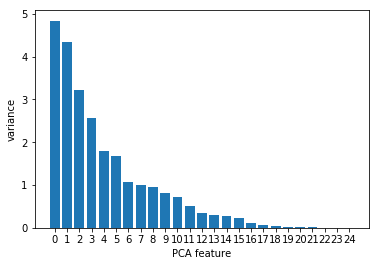

In [18]:
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit_transform(X)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()